# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
!ls

AZDIAS_Feature_Summary.csv
Data_Dictionary.md
Identify_Customer_Segments.ipynb
Udacity_AZDIAS_Subset.csv
Udacity_CUSTOMERS_Subset.csv


In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';',)

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias['OST_WEST_KZ'].head(10)

0    NaN
1      W
2      W
3      W
4      W
5      W
6      W
7      W
8      W
9      W
Name: OST_WEST_KZ, dtype: object

In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [8]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [9]:
pd.unique(feat_info['missing_or_unknown'])

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

def missing_to_nans(azdias,summary): 
    
    # this takes teh azdias dataframe and the summary data frame and convert missing values to nans 
    #in azdias dataframe based on info in teh summary dataframe
    
    for col in range(azdias.shape[1]):
        
       
        missing_list=summary.iloc[col]['missing_or_unknown'][1:-1].split(',')

        # parse the missing list so that it can be used to assign nans. this jsut convert from string to integers and alpha
        missing_list_parsed = []
        for x in missing_list:
            if x.lstrip('-').isnumeric():
                
                missing_list_parsed.append(int(x))
            else:
                missing_list_parsed.append(x)
    
        azdias.iloc[:,col].replace(missing_list_parsed,np.nan,inplace=True)
    
    
    

In [11]:
# convert missing to nans based on feat_info

missing_to_nans(azdias,feat_info)

In [12]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

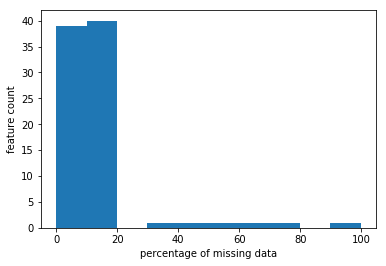

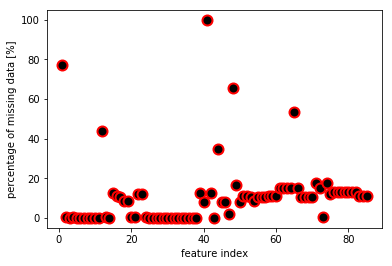

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_percentage = 100*azdias.isnull().sum()/len(azdias)


plt.subplot(1,2,1)

plt.axes()

plt.hist(missing_data_percentage)
plt.ylabel('feature count')
plt.xlabel('percentage of missing data')
plt.show()

plt.subplot(1,2,2)
plt.axes()
plt.ylabel('percentage of missing data [%]')
plt.xlabel('feature index')

plt.scatter(1+np.arange(azdias.shape[1]),missing_data_percentage , s = 100 , c = 'k' , linewidths=2,edgecolors='r')
plt.show()



In [14]:
mask = missing_data_percentage>=20

In [15]:
print('outlier feature which has more that 20% missing data')
print(list(azdias.loc[:,mask].columns))
print('number of features:',len(list(azdias.loc[:,mask].columns)))

outlier feature which has more that 20% missing data
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
number of features: 6


In [16]:
# Investigate patterns in the amount of missing data in each column.

mask2 = (missing_data_percentage>10) & ( missing_data_percentage<20)

print('features which have missing between 10% - 20%:')
print('number of features:',len(list(azdias.loc[:,mask2].columns)))


features which have missing between 10% - 20%:
number of features: 40


In [17]:
# how many features have no missing data:

mask3=~azdias.isna().any()

print('features with no missing values:')
print(list(azdias.loc[:,mask3].columns))
print('number of features:',len(list(azdias.loc[:,mask3].columns)))

features with no missing values:
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
number of features: 24


In [18]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns2drop=list(azdias.loc[:,mask].columns)
azdias.drop(columns=columns2drop,axis=1,inplace=True)


In [19]:
azdias.shape

(891221, 79)

In [20]:
feat_info = feat_info[~feat_info['attribute'].isin(columns2drop)]
feat_info.shape

(79, 4)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The amount of missing data can be divided into three parts

**outlier data**: which have more than 20% missing data: total 5 features in this data 


**missing data**: in which columns have less than 20% of their data missing: a total of  53 features


**complete data**: in which the columns have no missing data: a total of 27 features 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

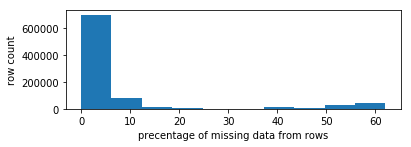

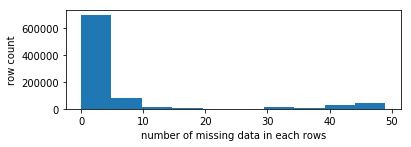

In [21]:
# How much data is missing in each row of the dataset?
row_missing_percentage = 100*azdias.isna().sum(axis=1)/azdias.shape[1]
row_missing_count=azdias.isna().sum(axis=1)




plt.subplot(2,1,1)
plt.axis()

plt.hist(row_missing_percentage)
plt.ylabel('row count')
plt.xlabel('precentage of missing data from rows')
plt.show()


plt.subplot(2,1,2)
plt.axis()

plt.hist(row_missing_count)
plt.ylabel('row count')
plt.xlabel('number of missing data in each rows')
plt.show()


In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_thresh = 5 # the threshhold number of data missing in each row 

mask_high=row_missing_count>row_thresh
mask_low = ~mask_high



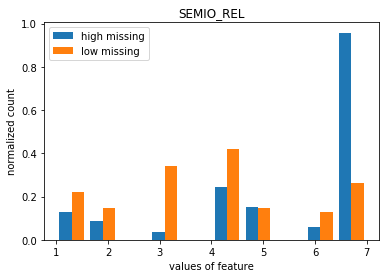

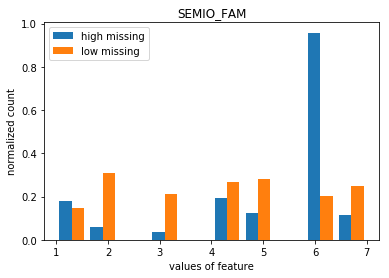

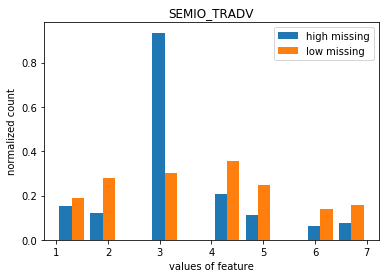

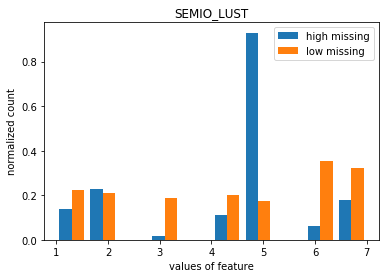

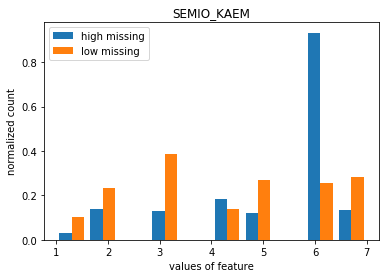

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# print(list(azdias.loc[:,mask3].columns))


# plt.hist([azdias.loc[mask_high,'SEMIO_MAT'],azdias.loc[mask_low,'SEMIO_MAT']],density=True)

def comapre_hist(azdias,mask_high):
    mask_low = ~mask_high
    mask3=~azdias.isna().any()

    columns = list(azdias.loc[:,mask3].columns)
    col2compare = 5
    np.random.seed(0)
    columns_choice=list(np.random.choice(columns,size=col2compare ,replace= False))
    
    for col in columns_choice:
        
        plt.subplot()
        plt.axis()
        plt.title(col)
        plt.hist([azdias.loc[mask_high,col],azdias.loc[mask_low,col]],
                 density=True,label=['high missing','low missing'])
#         plt.hist(azdias.loc[mask_high,col],
#                  density=True,label='high missing')
#         plt.hist(azdias.loc[mask_low,col],
#                  density=True,label='low missing')
        plt.xlabel('values of feature')
        plt.ylabel('normalized count')
        plt.legend()
        plt.show()
    
    
    
    
   
    
comapre_hist(azdias,mask_high)

#### Discussion 1.1.3: Assess Missing Data in Each Row

based on the above five normalized histograms, it can be seen that the distribution similarity between the two datasets ( lots of missing and few missing) depends on the features selected. some feature like 'FINANZ_SPARER' seems to have a good level of aggregate between the two datasets. while other features show variation. in my opinion, the w two data sets cannot be considered to behave similar distribution. so the two datasets are qualitatively different.   are different in their distributions.

In [24]:
# investigate how much data I'll drop 

original_len = len(azdias)
dropped_len = len(azdias.dropna())
print('precentage of dropped data when dropping any row with nan:',100*(1-(dropped_len/original_len)))

reduced_len = len(azdias.dropna(thresh=azdias.shape[1]-(row_thresh+1)))#len(azdias.loc[mask_low,:])

print('precentage of dropped data when dropping rows which has a threshhold values of nan:',100*(1-(reduced_len/original_len)))

precentage of dropped data when dropping any row with nan: 30.07245116531141
precentage of dropped data when dropping rows which has a threshhold values of nan: 17.708963321106662


In [25]:
# drop data with threshold 

azdias.dropna(thresh=azdias.shape[1]-(row_thresh+1),inplace=True)




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [26]:
# How many features are there of each data type?

print(pd.unique(feat_info.iloc[:,2]))
for data_type in list(pd.unique(feat_info.iloc[:,2])):
    print(data_type,(feat_info.iloc[:,2]==data_type).sum())

['ordinal' 'categorical' 'mixed' 'numeric']
ordinal 49
categorical 18
mixed 6
numeric 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [27]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary_feat = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP']
binary_feat_non_numeric = ['OST_WEST_KZ']

binary = binary_feat + binary_feat_non_numeric

In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

# first re-encode binary to 0 and 1 only for consistency

for col in binary:
    
    unique_val = azdias[col].dropna().unique()
    c = {unique_val[0]:0 , unique_val[1]:1}
    azdias[col]=azdias[col].map(c)
    
# find categorical columns with more than 2 values:

cat_mask=feat_info.type=='categorical'

all_cat = list(feat_info[cat_mask].iloc[:,0])

cat_2plus = [x for x in all_cat if x not in binary]

# azdias = pd.get_dummies(azdias,columns=cat_2plus )

# drop all multi-level categorical features
azdias.drop(labels=cat_2plus , axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

Binary categorical features were kept. they were mapped to ```[0,1] ```. The multi-level features  were removed completely for simplicity

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# 0 is avantgarde  and 1 isMainstream 

map_binary = {
              1.0:  1,
              2.0:  0,
              3.0:  1,
              4.0:  0,
              5.0:  1,
              6.0:  0,
              7.0:  0,
              8.0:  1,
              9.0:  0,
              10.0: 1,
              11.0: 0,
              12.0: 1,
              13.0: 0,
              14.0: 1,
              15.0: 0
}

# 1 ==> 40 , 2==> 50 , 3==> 60 , 4==> 70 , 5==> 80 , 5==> 90
map_interval = {
                  1.0:  1,
                  2.0:  1,
                  3.0:  2,
                  4.0:  2,
                  5.0:  3,
                  6.0:  3,
                  7.0:  3,
                  8.0:  4,
                  9.0:  4,
                  10.0: 5,
                  11.0: 5,
                  12.0: 5,
                  13.0: 5,
                  14.0: 6,
                  15.0: 6
}
azdias['PRAEGENDE_JUGENDJAHRE_binary']=azdias.PRAEGENDE_JUGENDJAHRE.map(map_binary)
azdias['PRAEGENDE_JUGENDJAHRE_interval']=azdias.PRAEGENDE_JUGENDJAHRE.map(map_interval)
azdias.drop(labels='PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
map_wealth={
            
            11.0:1,
            12.0:1,
            13.0:1,
            14.0:1,
            15.0:1,
            21.0:2,
            22.0:2,
            23.0:2,
            24.0:2,
            25.0:2,
            31.0:3,
            32.0:3,
            33.0:3,
            34.0:3,
            35.0:3,
            41.0:4,
            42.0:4,
            43.0:4,
            44.0:4,
            45.0:4,
            51.0:5,
            52.0:5,
            53.0:5,
            54.0:5,
            55.0:5  
}

map_life={
            
            11.0:1,
            12.0:2,
            13.0:3,
            14.0:4,
            15.0:5,
            21.0:1,
            22.0:2,
            23.0:3,
            24.0:4,
            25.0:5,
            31.0:1,
            32.0:2,
            33.0:3,
            34.0:4,
            35.0:5,
            41.0:1,
            42.0:2,
            43.0:3,
            44.0:4,
            45.0:5,
            51.0:1,
            52.0:2,
            53.0:3,
            54.0:4,
            55.0:5  
}

azdias.CAMEO_INTL_2015=azdias.CAMEO_INTL_2015.apply(lambda x: float(x))
azdias['CAMEO_INTL_2015_wealth']=azdias.CAMEO_INTL_2015.map(map_wealth)
azdias['CAMEO_INTL_2015_life']=azdias.CAMEO_INTL_2015.map(map_life)
azdias.drop(labels='CAMEO_INTL_2015',axis=1,inplace=True)

In [46]:
azdias.shape[1]

68

In [48]:
# drop other mixed values:


mixed_mask=feat_info.type=='mixed'

all_mixed = list(feat_info[mixed_mask].iloc[:,0])

mixed_2drop = [x for x in all_mixed if x in list(azdias.columns)]



# drop all remaining mixed  features
azdias.drop(labels=mixed_2drop  , axis=1, inplace=True)
azdias.shape[1]

64

#### Discussion 1.2.2: Engineer Mixed-Type Features

Regarding the mixed values, all of them were dropped from analysis except  ```PRAEGENDE_JUGENDJAHRE``` and ```CAMEO_INTL_2015```

```PRAEGENDE_JUGENDJAHRE``` were encoded into a binary feature and an interval features 

```CAMEO_INTL_2015``` were encoded into two interval features

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
azdias.reset_index(drop=True,inplace=True)
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733395 entries, 0 to 733394
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              731412 non-null float64
ANREDE_KZ                         733395 non-null int64
FINANZ_MINIMALIST                 733395 non-null int64
FINANZ_SPARER                     733395 non-null int64
FINANZ_VORSORGER                  733395 non-null int64
FINANZ_ANLEGER                    733395 non-null int64
FINANZ_UNAUFFAELLIGER             733395 non-null int64
FINANZ_HAUSBAUER                  733395 non-null int64
GREEN_AVANTGARDE                  733395 non-null int64
HEALTH_TYP                        715877 non-null float64
RETOURTYP_BK_S                    733395 non-null float64
SEMIO_SOZ                         733395 non-null int64
SEMIO_FAM                         733395 non-null int64
SEMIO_REL                         733395 non-null int64
SEMIO_MAT                         733395 non-null int64
SEMIO_VERT                        733395 no

In [514]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [515]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
def clean_data(df,df_support):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    df_clean = df
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    for col in range(df.shape[1]):

        missing_list=df_support.iloc[col]['missing_or_unknown'][1:-1].split(',')

        # parse the missing list so that it can be used to assign nans. this jsut convert from string to integers and alpha
        missing_list_parsed = []
        for x in missing_list:
            if x.lstrip('-').isnumeric():
                
                missing_list_parsed.append(int(x))
            else:
                missing_list_parsed.append(x)
    
        df_clean.iloc[:,col] = df.iloc[:,col].replace(missing_list_parsed,np.nan)
    
    
    # remove selected columns and rows, ...
    
    # drop outlier columns:
    columns2drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean.drop(columns=columns2drop,axis=1,inplace=True)
    df_support = df_support[~df_support['attribute'].isin(columns2drop)]
    # drop rows based on a thershhold of missing data:
    row_thresh = 5 # the threshhold number of data missing in each row 
    df_clean.dropna(thresh=df_clean.shape[1]-(row_thresh+1),inplace=True)
    
    
    # select, re-encode, and engineer column values.
    
    
    binary = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ','VERS_TYP','OST_WEST_KZ']
    
    # Re-encode categorical variable(s) to be kept in the analysis.

    # first re-encode binary to 0 and 1 only for consistency

    for col in binary:

        unique_val = df_clean[col].dropna().unique()
        c = {unique_val[0]:0 , unique_val[1]:1}
        df_clean[col]=df_clean[col].map(c)

    # find categorical columns with more than 2 values:

    cat_mask=df_support.type=='categorical'

    all_cat = list(df_support[cat_mask].iloc[:,0])

    cat_2plus = [x for x in all_cat if x not in binary]

    

    # drop all multi-level categorical features
    df_clean.drop(labels=cat_2plus , axis=1, inplace=True)
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    # 0 is avantgarde  and 1 isMainstream 

    map_binary = {
                  1.0:  1,
                  2.0:  0,
                  3.0:  1,
                  4.0:  0,
                  5.0:  1,
                  6.0:  0,
                  7.0:  0,
                  8.0:  1,
                  9.0:  0,
                  10.0: 1,
                  11.0: 0,
                  12.0: 1,
                  13.0: 0,
                  14.0: 1,
                  15.0: 0
    }

    # 1 ==> 40 , 2==> 50 , 3==> 60 , 4==> 70 , 5==> 80 , 5==> 90
    map_interval = {
                      1.0:  1,
                      2.0:  1,
                      3.0:  2,
                      4.0:  2,
                      5.0:  3,
                      6.0:  3,
                      7.0:  3,
                      8.0:  4,
                      9.0:  4,
                      10.0: 5,
                      11.0: 5,
                      12.0: 5,
                      13.0: 5,
                      14.0: 6,
                      15.0: 6
    }
    df_clean['PRAEGENDE_JUGENDJAHRE_binary']=df_clean.PRAEGENDE_JUGENDJAHRE.map(map_binary)
    df_clean['PRAEGENDE_JUGENDJAHRE_interval']=df_clean.PRAEGENDE_JUGENDJAHRE.map(map_interval)
    df_clean.drop(labels='PRAEGENDE_JUGENDJAHRE',axis=1,inplace=True)
    
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    map_wealth={

                11.0:1,
                12.0:1,
                13.0:1,
                14.0:1,
                15.0:1,
                21.0:2,
                22.0:2,
                23.0:2,
                24.0:2,
                25.0:2,
                31.0:3,
                32.0:3,
                33.0:3,
                34.0:3,
                35.0:3,
                41.0:4,
                42.0:4,
                43.0:4,
                44.0:4,
                45.0:4,
                51.0:5,
                52.0:5,
                53.0:5,
                54.0:5,
                55.0:5  
    }

    map_life={

                11.0:1,
                12.0:2,
                13.0:3,
                14.0:4,
                15.0:5,
                21.0:1,
                22.0:2,
                23.0:3,
                24.0:4,
                25.0:5,
                31.0:1,
                32.0:2,
                33.0:3,
                34.0:4,
                35.0:5,
                41.0:1,
                42.0:2,
                43.0:3,
                44.0:4,
                45.0:5,
                51.0:1,
                52.0:2,
                53.0:3,
                54.0:4,
                55.0:5  
    }

    df_clean.CAMEO_INTL_2015=df_clean.CAMEO_INTL_2015.apply(lambda x: float(x))
    df_clean['CAMEO_INTL_2015_wealth']=df_clean.CAMEO_INTL_2015.map(map_wealth)
    df_clean['CAMEO_INTL_2015_life']=df_clean.CAMEO_INTL_2015.map(map_life)
    df_clean.drop(labels='CAMEO_INTL_2015',axis=1,inplace=True)
    
    # drop other mixed values:

    mixed_mask=df_support.type=='mixed'
    all_mixed = list(df_support[mixed_mask].iloc[:,0])
    mixed_2drop = [x for x in all_mixed if x in list(df_clean.columns)]
    # drop all remaining mixed  features
    
    df_clean.drop(labels=mixed_2drop  , axis=1, inplace=True)
    df_clean.reset_index(drop=True,inplace=True)
    # Return the cleaned dataframe.
    return df_clean
    

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [7]:
azdias= pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';',)

# Load in the feature summary file.
df2 = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [8]:
azdias = clean_data(azdias,df2)

In [9]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733395 entries, 0 to 733394
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              731412 non-null float64
ANREDE_KZ                         733395 non-null int64
FINANZ_MINIMALIST                 733395 non-null int64
FINANZ_SPARER                     733395 non-null int64
FINANZ_VORSORGER                  733395 non-null int64
FINANZ_ANLEGER                    733395 non-null int64
FINANZ_UNAUFFAELLIGER             733395 non-null int64
FINANZ_HAUSBAUER                  733395 non-null int64
GREEN_AVANTGARDE                  733395 non-null int64
HEALTH_TYP                        715877 non-null float64
RETOURTYP_BK_S                    733395 non-null float64
SEMIO_SOZ                         733395 non-null int64
SEMIO_FAM                         733395 non-null int64
SEMIO_REL                         733395 non-null int64
SEMIO_MAT                         733395 non-null int64
SEMIO_VERT                        733395 no

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [10]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# temporarily remove missing values from azdias:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(azdias)



C:\Users\SMART\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
# Apply feature scaling to the general population demographics data.

azdias = pd.DataFrame(scaler.transform(azdias.fillna(method='ffill')),columns=azdias.columns)

C:\Users\SMART\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


### Discussion 2.1: Apply Feature Scaling

```StandardScaler``` is used to perform the scaling. first, the nan's values are ignored to calculate the scaling parameters. then the nan values are filled using a simple forward fill for each column of data ( the filling is applied considering the values in each column). after filling the nan's the whole data is scaled using the previously obtained scaling parameters 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [12]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

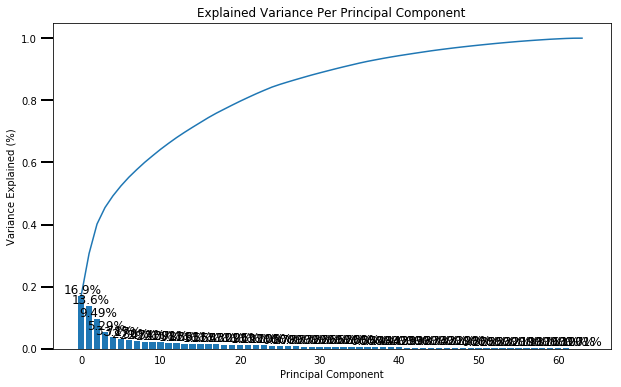

In [13]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [14]:
pca.explained_variance_ratio_.sum()

0.9999999999999999

In [16]:
# Re-apply PCA to the data while selecting for number of components to retain.
for comp in range(20, azdias.shape[1]):
    pca = PCA(n_components=comp)
    pca.fit(azdias)
    if pca.explained_variance_ratio_.sum() >= 0.85:
        break


In [17]:
comp

26

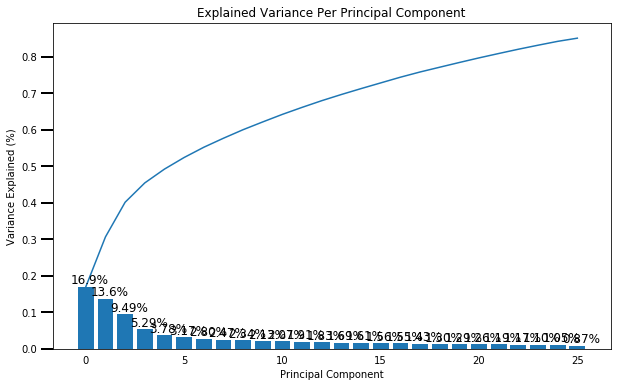

In [18]:
scree_plot(pca)

In [19]:
n_comp = comp
columns = azdias.columns
azdias=pca.transform(azdias)

### Discussion 2.2: Perform Dimensionality Reduction

the number of components to retained were chosen based on achieving a minimum of 85% commultive variance explained. this led to choosing 26 compoemnts out of 64 which is about 60% reduction in total components. notice that the scree plot shows that you can get variance explained at almost 70% level by keeping only 10 components

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [20]:
def ordered_weight(pca,columns,pca_comp,topk):
    '''
    reates a pandas data frame which shows the 'topk' weight and their corresponding feature name. this gives both the 
    largest topk weights and also the smallest topk in different columns in the data frame.  
    
    INPUT: pca - the result of instantiation of PCA in scikit learn
           columns - list of columns name for the original features
           pca_comp - the ith pca component to create the ordered data frame 
           topk - number of largest and smallest weights to be shown in the date frame 
            
    OUTPUT:
            ordered_df - data frame of ordered weights and feature columns  
    '''
    pca_weight = pca.components_[pca_comp-1,:]
    
    # ordered largest topk 
    weight_pos=np.sort(pca_weight)[::-1][0:topk]
    columns_pos = columns[np.argsort(pca_weight)[::-1]][0:topk]
    
    # ordered smallest topk 
    weight_neg=np.sort(pca_weight)[0:topk]
    columns_neg = columns[np.argsort(pca_weight)][0:topk]
    
    # create data frame with ordered information 
    
    d= {
        'weight_pos':weight_pos,
        'col_pos': columns_pos,
        'weight_neg':weight_neg,
        'col_neg': columns_neg
        
        
    }
    ordered_df = pd.DataFrame(d)
    
    return ordered_df



In [21]:

k = 5


In [22]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
ith_comp = 1
df_ordered = ordered_weight(pca,columns,ith_comp,k)
df_ordered

,weight_pos,col_pos,weight_neg,col_neg
0,0.224942,PLZ8_ANTG3,-0.241090,MOBI_REGIO
1,0.218102,PLZ8_ANTG4,-0.225035,PLZ8_ANTG1
2,0.205565,CAMEO_INTL_2015_wealth,-0.224673,KBA05_ANTG1
3,0.202519,HH_EINKOMMEN_SCORE,-0.219200,FINANZ_MINIMALIST
4,0.194836,ORTSGR_KLS9,-0.216203,KBA05_GBZ


In [23]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
ith_comp = 2
df_ordered = ordered_weight(pca,columns,ith_comp,k)
df_ordered

,weight_pos,col_pos,weight_neg,col_neg
0,0.255759,ALTERSKATEGORIE_GROB,-0.256409,SEMIO_REL
1,0.229619,SEMIO_ERL,-0.245744,PRAEGENDE_JUGENDJAHRE_interval
2,0.228691,FINANZ_VORSORGER,-0.234262,FINANZ_SPARER
3,0.180972,SEMIO_LUST,-0.228784,SEMIO_TRADV
4,0.165738,RETOURTYP_BK_S,-0.227991,SEMIO_PFLICHT


In [24]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

ith_comp = 3
df_ordered = ordered_weight(pca,columns,ith_comp,k)
df_ordered

,weight_pos,col_pos,weight_neg,col_neg
0,0.369131,ANREDE_KZ,-0.337821,SEMIO_KAEM
1,0.347745,SEMIO_VERT,-0.313717,SEMIO_DOM
2,0.263380,SEMIO_SOZ,-0.270995,SEMIO_KRIT
3,0.251127,SEMIO_FAM,-0.217993,SEMIO_RAT
4,0.232864,SEMIO_KULT,-0.188024,FINANZ_ANLEGER


### Discussion 2.3: Interpret Principal Components

#### first component:

the first principle component is positively correlated with: 
- the increase in the share of multi-family houses
- the increase in the size of the community
- the high movement pattern.  

in contrast, the first principle component is negatively correlated with: 
- the wealth of the household 
- net income. 

#### second component:

the second  principal component is positively correlated with: 
-  the person's age 
- personality being  more systems-based thinking, religious, and money saver
- financially less prepared person.  

in contrast, the second principal component is negatively correlated with: 
- personality being  sensual 
- personality being a crazy shopper

#### thrid component:

the third   principal component is positively correlated with: 
-  the person's being female 
- personality being  dominant-minded, rational, and economically more investor 
  

in contrast, the  third principal component is negatively correlated with: 
- personality being  dreamful, socially minded, and family oriented



**so in summary, the first component describes a low-class community with small net income, the second describes the personality of a conservative person. the third describes the gender and some other personal traits** 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [28]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_values = range(3,26)

score_kmeans=[]
score_kmeans2=[]
for k in k_values:
    print('at ',k,'out of ',k_values[-1])
    kmeans = KMeans(n_clusters=k,n_jobs=-1,n_init=8,tol=.001,random_state=1,precompute_distances=True)
    kmeans.fit(azdias)
    predictions = kmeans.predict(azdias)

#     score_kmeans.append(silhouette_score(azdias, predictions)) 
    score_kmeans.append(kmeans.score(azdias)) 
    score_kmeans2.append((kmeans.inertia_)/len(azdias))
    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    


at  3 out of  25
at  4 out of  25
at  5 out of  25
at  6 out of  25
at  7 out of  25
at  8 out of  25
at  9 out of  25
at  10 out of  25
at  11 out of  25
at  12 out of  25
at  13 out of  25
at  14 out of  25
at  15 out of  25
at  16 out of  25
at  17 out of  25
at  18 out of  25
at  19 out of  25
at  20 out of  25
at  21 out of  25
at  22 out of  25
at  23 out of  25
at  24 out of  25
at  25 out of  25


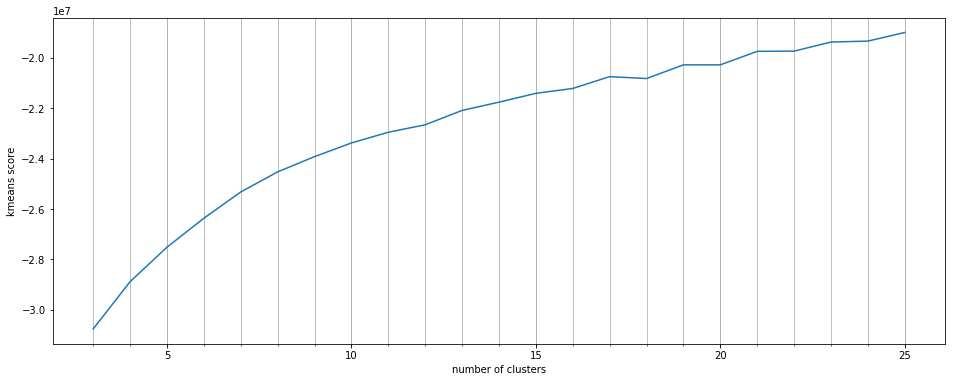

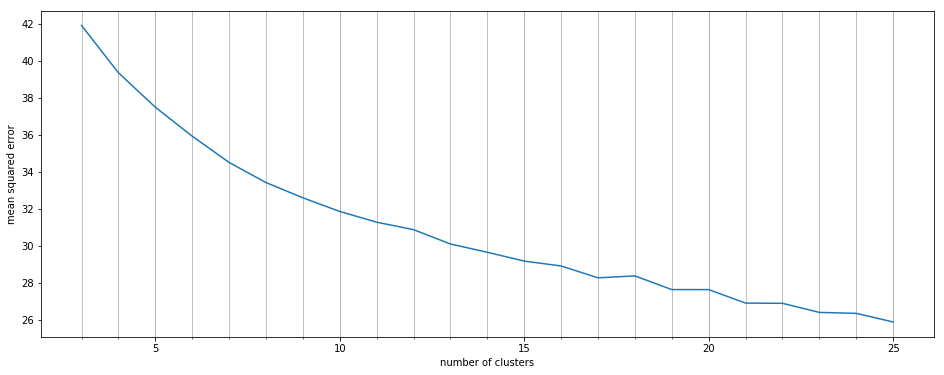

In [34]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
xticks = k_values

fig, ax = plt.subplots(figsize=(16, 6))

plt.plot(k_values, score_kmeans)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')              
plt.xlabel('number of clusters')
plt.ylabel('kmeans score')
plt.show()


fig, ax = plt.subplots(figsize=(16, 6))

plt.plot(k_values, score_kmeans2)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')  
plt.xlabel('number of clusters')
plt.ylabel('mean squared error')
plt.show()

In [35]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k=17
kmeans = KMeans(n_clusters=k,n_jobs=-1,n_init=8,tol=.001,random_state=1,precompute_distances=True)
kmeans.fit(azdias)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=17, n_init=8, n_jobs=-1, precompute_distances=True,
    random_state=1, tol=0.001, verbose=0)

In [46]:
azdias_clusters = kmeans.predict(azdias)

### Discussion 3.1: Apply Clustering to General Population

based on the value of the mean squared error, it can be seen that a good value that compromises the diminishing return of error reduction is about 17 clusters. so teh data is composed of 17 clusters 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [36]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [37]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers,df2)



In [38]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130927 entries, 0 to 130926
Data columns (total 64 columns):
ALTERSKATEGORIE_GROB              130729 non-null float64
ANREDE_KZ                         130927 non-null int64
FINANZ_MINIMALIST                 130927 non-null int64
FINANZ_SPARER                     130927 non-null int64
FINANZ_VORSORGER                  130927 non-null int64
FINANZ_ANLEGER                    130927 non-null int64
FINANZ_UNAUFFAELLIGER             130927 non-null int64
FINANZ_HAUSBAUER                  130927 non-null int64
GREEN_AVANTGARDE                  130927 non-null int64
HEALTH_TYP                        129240 non-null float64
RETOURTYP_BK_S                    130927 non-null float64
SEMIO_SOZ                         130927 non-null int64
SEMIO_FAM                         130927 non-null int64
SEMIO_REL                         130927 non-null int64
SEMIO_MAT                         130927 non-null int64
SEMIO_VERT                        130927 no

In [40]:
customers =pd.DataFrame(scaler.transform(customers.fillna(method='ffill')),columns=customers.columns)

C:\Users\SMART\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [41]:
customers = pca.transform(customers)

In [42]:
customers_clusters=kmeans.predict(customers)

In [67]:
print('percentage of data points in each clusters for azdias (sorted):')
print(np.round(np.sort((100*azdias_cluster_count/len(azdias)))[::-1],decimals=1))
print(np.argsort((100*azdias_cluster_count/len(azdias)))[::-1])

percentage of data points in each clusters for azdias (sorted):
[9.5 9.1 9.  9.  7.1 6.8 6.7 6.4 6.4 5.7 5.1 4.7 4.6 4.4 4.3 0.8 0.4]
[ 3  1  4  2  0 15 11  6 13  5  9 14 16  8 10 12  7]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population

customers_unique, customers_cluster_count = np.unique(customers_clusters, return_counts=True)
azdias_unique, azdias_cluster_count = np.unique(azdias_clusters, return_counts=True)

customers_cluster_percentage=100*customers_cluster_count/len(customers)
print('percentage of data points in each clusters for customers (sorted):')
print(np.round(np.sort((customers_cluster_percentage))[::-1],decimals=1))
print(np.argsort((customers_cluster_percentage))[::-1])

azdiads_cluster_percentage=100*azdias_cluster_count/len(azdias)
print('percentage of data points in each clusters for azdias (sorted):')
print(np.round(np.sort((azdiad_cluster_percentage))[::-1],decimals=1))
print(np.argsort((azdiad_cluster_percentage))[::-1])

percentage of data points in each clusters for customers (sorted):
[97.   2.   0.3  0.1  0.1  0.1  0.1  0.1  0.1  0.   0.   0.   0.   0.
  0.   0.   0. ]
[12  7 10  1  9  5 11  4 16 14 13  8  0  2  6  3 15]
percentage of data points in each clusters for azdias (sorted):
[9.5 9.1 9.  9.  7.1 6.8 6.7 6.4 6.4 5.7 5.1 4.7 4.6 4.4 4.3 0.8 0.4]
[ 3  1  4  2  0 15 11  6 13  5  9 14 16  8 10 12  7]


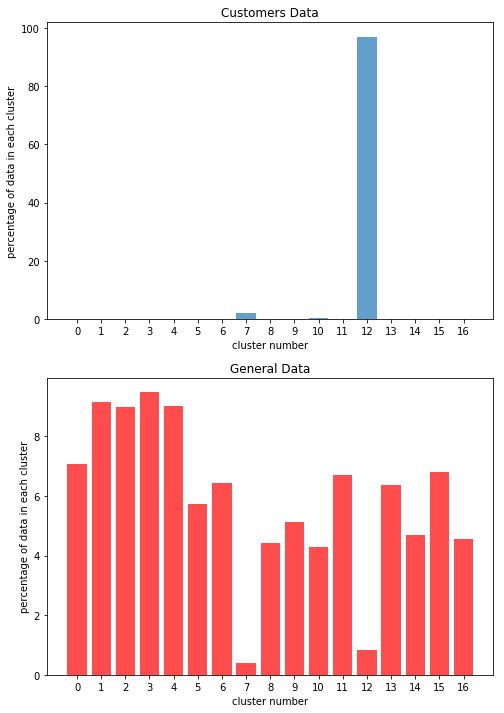

In [96]:
fig = plt.figure(figsize=(8,12))
ax1 = fig.add_subplot(2,1,1)
ax1.set_xticks(customers_unique,minor=False)
ax1.set_xlabel('cluster number')
ax1.set_ylabel('percentage of data in each cluster')
ax1.title.set_text('Customers Data')
plt.bar(customers_unique,customers_cluster_percentage,alpha=.7)



ax2 = fig.add_subplot(2,1,2)
ax2.set_xticks(azdias_unique,minor=False)
ax2.set_xlabel('cluster number')
ax2.set_ylabel('percentage of data in each cluster')
ax2.title.set_text('General Data')

plt.bar(azdias_unique,azdiads_cluster_percentage,alpha=.7,color='r')
plt.show()

In [94]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

print('the first three coordiantes for the cluster number 12: ')
kmeans.cluster_centers_[12,0:3]

the first three coordiantes for the cluster number 12: 


array([-0.23739021, -0.20616053,  0.01199687])

In [97]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

print('the first three coordiantes for the cluster number 15: ')
kmeans.cluster_centers_[15,0:3]

the first three coordiantes for the cluster number 15: 


array([ 4.4959808 , -1.29718272, -2.74462731])

### Discussion 3.3: Compare Customer Data to Demographics Data

from the percentage of the data in the cluster plots above, we can see the customers data belongs almost exclusively to cluster number 12. analyzing cluster 12 in more details shows that the first and second coordinate of the cluster center is negative. referring to the analysis done in part 2.3, we can interpret these values as  segments of the population who are generally wealthy, live in fancy villas, and considered to have money spending behaviors.

on the other hand, cluster number 15 is one o the most underrepresented cluster in the customer data. analyzing the coordinates of the cluster center shows that the people that belongs to it are considered generally less wealthy and less obsessed with shopping and live in multi-family houses. 

so the data for the customers comes from segment of the population who are wealthy and live in fancy places and who are characterized as shopping savvy

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.